In [1]:
# IMPORTS
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from skimage import color
from skimage import io
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
drive = True

if drive:
    from google.colab import drive
    # MOUNT DRIVE
    drive.mount('/content/drive', force_remount=True)
    data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/'
    raw_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/raw_samples/'
    synth_data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/synth_samples/'
    results_path = '/content/drive/My Drive/DeepLearning_2023/Final/Results/'
else: # LOCAL
    data_path = './Data/'
    raw_data_path = './Data/raw_samples/'
    results_path = './Results/'

Mounted at /content/drive


In [3]:
# UTILS
def one_hot_encode_multiple_classes(array, n_classes=36):
    output = [0]*(len(array)*n_classes)
    for i, _class in enumerate(array):
        output[(i)*(n_classes) + (_class)] = 1
    return output

def one_hot_decode_multiple_classes(one_hot, n_classes=36):
    length = len(one_hot)//n_classes
    output = [0]*length
    for i in range(length):
        _class = np.argmax(one_hot[(i*n_classes):((i+1)*n_classes)])
        output[i] = _class
    return output

def all_character_to_int(array):
    output = [single_character_to_int(c) for c in array]
    return output

def all_int_to_character(array):
    output = [int_to_single_character(int(i)) for i in array]
    return output

def single_character_to_int(c): # Converts char to int label
    if c.isdigit():
        return int(int(c))
    else:
        return int(ord(c) - 87)

def int_to_single_character(i): # Converts int label to char
    if i<10:
        return str(i)
    else:
        return str(chr(int(i) + 87))

def squareImage(img, target_size = 192): # INPUT IMG MUST BE PIL IMAGE RGBA: RETURNS NUMPY ARRAY OF SIZE 192x192x4
    if img.mode == "RGBA":
        channels = 4
    elif img.mode == "RGB":
        channels = 3
    else:
        print("Image with wrong mode")
    img_np = np.array(img.getdata()).reshape(img.size[1], img.size[0], channels)
    #PADDING
    y,x,_ = img_np.shape
    pad_y = max(0, (target_size - y)//2)
    pad_x = max(0, (target_size - x)//2)
    img_np = np.pad(img_np, ((pad_y, pad_y),(pad_x, pad_x),(0, 0)), "edge")
    # CROPPING
    y,x,_ = img_np.shape
    startx = x//2-(target_size//2)
    starty = y//2-(target_size//2)
    img_np = img_np[starty:starty+192,startx:startx+192]
    return img_np

In [4]:
#CaptchaDataset class
class CaptchaDataset(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self, dataPath = raw_data_path, transform = None):
        self.data = []
        self.labels = []
        directory_files = os.listdir(dataPath)
        for filename in directory_files:
            self.data.append(np.array(squareImage(Image.open(dataPath+filename)))[:,:,0])
            self.labels.append(all_character_to_int(list(filename[:5])))
        self.data=np.array(self.data)
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[index]
        lbl = torch.Tensor(self.labels[index])
        data = Image.fromarray((data).astype(np.uint8))
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

In [5]:
# Image transformer
tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

#Instantiating captchaDataset
captchaDataset = CaptchaDataset(raw_data_path, tr)
print("captchaDataset created:")
print(" ", len(captchaDataset), "images")
print(" ", captchaDataset.data.shape)

# Setting train and test sizes
train_size = int(len(captchaDataset) * 0.7)
test_size = len(captchaDataset) - train_size

# Dataset splitting (inputs Dataset and outputs a dataset.Subset (which has same properties and methods as Dataset)))
train_set, test_set = torch.utils.data.random_split(captchaDataset,[train_size,test_size], generator=torch.Generator().manual_seed(42))
print("Dataset splitted:")
print("  Training set len:", len(train_set))
print("  Testing set len:", len(test_set))

captchaDataset created:
  1080 images
  (1080, 192, 192)
Dataset splitted:
  Training set len: 756
  Testing set len: 324


['g', 'p', '2', '2', 'x']


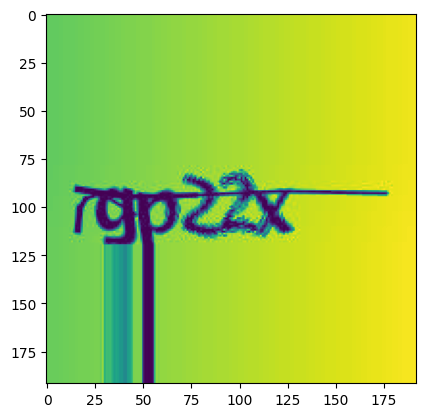

In [6]:
# Dataset sample example
data, lbl = captchaDataset.__getitem__(252)
plt.imshow(data.numpy()[0])
print(all_int_to_character(lbl.numpy().tolist()))

In [7]:
class MyMobileNetV2(nn.Module):
    def __init__(self, num_classes=36):
        super(MyMobileNetV2, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.05)
        t = 1
        self.conv20 = nn.Conv2d(16, 16*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn20 = nn.BatchNorm2d(16*t)
        self.conv21 = nn.Conv2d(16*t, 16, kernel_size=3, stride=1, padding=1, groups=16, bias=False)
        self.bn21 = nn.BatchNorm2d(16)
        self.conv22 = nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn22 = nn.BatchNorm2d(32)

        t = 4
        self.conv30 = nn.Conv2d(32, 32*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn30 = nn.BatchNorm2d(32*t)
        self.conv31 = nn.Conv2d(32*t, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False)
        self.bn31 = nn.BatchNorm2d(32)
        self.conv32 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn32 = nn.BatchNorm2d(64)

        self.conv40 = nn.Conv2d(64, 64*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn40 = nn.BatchNorm2d(64*t)
        self.conv41 = nn.Conv2d(64*t, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False)
        self.bn41 = nn.BatchNorm2d(64)
        self.conv42 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn42 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.05)

        self.conv50 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn50 = nn.BatchNorm2d(128*t)
        self.conv51 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn51 = nn.BatchNorm2d(128)
        self.conv52 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn52 = nn.BatchNorm2d(128)

        self.conv60 = nn.Conv2d(128, 128*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn60 = nn.BatchNorm2d(128*t)
        self.conv61 = nn.Conv2d(128*t, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn61 = nn.BatchNorm2d(128)
        self.conv62 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn62 = nn.BatchNorm2d(256)


        self.conv70 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn70 = nn.BatchNorm2d(256*t)
        self.conv71 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn71 = nn.BatchNorm2d(256)
        self.conv72 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn72 = nn.BatchNorm2d(256)
        self.dropout7 = nn.Dropout(0.05)

        self.conv80 = nn.Conv2d(256, 256*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn80 = nn.BatchNorm2d(256*t)
        self.conv81 = nn.Conv2d(256*t, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn81 = nn.BatchNorm2d(256)
        self.conv82 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn82 = nn.BatchNorm2d(512)

        t=1
        self.conv90 = nn.Conv2d(512, 512*t, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn90 = nn.BatchNorm2d(512*t)
        self.conv91 = nn.Conv2d(512*t, 512, kernel_size=3, stride=1, padding=1, groups=256, bias=False)
        self.bn91 = nn.BatchNorm2d(512)
        self.conv92 = nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn92 = nn.BatchNorm2d(1024)

        self.relu6 = nn.ReLU6(inplace=True)
        self.MaxPool2d= nn.MaxPool2d(kernel_size=2, stride=2)
        self.AvgPool2d = nn.AvgPool2d(6,stride=6)
        #self.AvgPool2d = nn.AvgPool2d(12)
        self.dropoutFc = nn.Dropout(0.1)
        self.FC = nn.Linear(512*4*2, 128*5)
        #self.fc = nn.Linear(1024, num_classes)
        self.dropoutF = nn.Dropout(0.05)
        self.FC2 = nn.Linear(128*5, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear) or  isinstance(m, nn.Conv2d):
           nn.init.xavier_uniform_(m.weight)

    def forward(self, x):

        #print(x.shape) -> INPUT: (192, 192, 1)
        out = self.relu6(self.bn1(self.conv1(x))) #-> OUTPUT: (192, 192, 16)
        out = self.dropout1(out)
        out = self.relu6(self.bn22(self.conv22(self.relu6(self.bn21(self.conv21(self.relu6(self.bn20(self.conv20(out))))))))) #-> OUTPUT: (192, 192, 32)
        out = self.MaxPool2d(out) #-> OUTPUT: (96, 96, 32)
        out = self.relu6(self.bn32(self.conv32(self.relu6(self.bn31(self.conv31(self.relu6(self.bn30(self.conv30(out))))))))) #-> OUTPUT: (96, 96, 64)
        out = self.relu6(self.bn42(self.conv42(self.relu6(self.bn41(self.conv41(self.relu6(self.bn40(self.conv40(out))))))))) #-> OUTPUT: (96, 96, 128)
        out = self.dropout4(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn52(self.conv52(self.relu6(self.bn51(self.conv51(self.relu6(self.bn50(self.conv50(out)))))))))+out  #-> OUTPUT: (48, 48, 128)
        out = self.relu6(self.bn62(self.conv62(self.relu6(self.bn61(self.conv61(self.relu6(self.bn60(self.conv60(out)))))))))  #-> OUTPUT: (48, 48, 256)
        out = self.relu6(self.bn72(self.conv72(self.relu6(self.bn71(self.conv71(self.relu6(self.bn70(self.conv70(out)))))))))+out #-> OUTPUT: (48, 48, 256)
        out = self.dropout7(out)
        out = self.MaxPool2d(out) #-> OUTPUT: (24, 24, 256)
        out = self.relu6(self.bn82(self.conv82(self.relu6(self.bn81(self.conv81(self.relu6(self.bn80(self.conv80(out))))))))) #-> OUTPUT: (24, 24, 512)
        out = self.MaxPool2d(out) #-> OUTPUT: (12, 12, 512)
        out = self.relu6(self.bn92(self.conv92(self.relu6(self.bn91(self.conv91(self.relu6(self.bn90(self.conv90(out))))))))) #-> OUTPUT: (12, 12, 512)
        out = self.AvgPool2d(out) #-> OUTPUT: (1, 1, 512)
        out = torch.flatten(out, 1)
        out = self.dropoutFc(out)
        out = self.FC(out)
        out = self.dropoutF(out)
        out = self.FC2(out)
        return out

In [8]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params += p.numel()
  return params

In [11]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu', test_loader=None):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    maxloss= 10000000
    losses_list = []
    accuracies = []
    full_accuracies = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0

        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            # Forward pass
            outputs = CNN(images)
            batch_size = len(outputs)
            outputs = torch.reshape(outputs, (batch_size, 36, 5))
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        if test_loader != None:
            CNN.eval()
            acc, full_acc = test(CNN, test_loader)
            accuracies.append(acc)
            full_accuracies.append(full_acc)
            print("Single char accuracy: {:.4f}% | Full string accuracy: {:.4f}%".format(acc, full_acc))
            CNN.train()
        if loss<maxloss:
            torch.save(CNN.state_dict(), results_path+ '/' + model_name)
            maxloss = loss

    return losses_list, accuracies, full_accuracies

# Test funcion
def test(CNN, test_loader, display_errors=False):
    CNN.eval()
    with torch.no_grad():
        correct = 0
        correct_full_words = 0
        total = 0
        total_full_words = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            batch_size = len(outputs)
            outputs = torch.reshape(outputs, (batch_size, 36, 5))
            # get predicted class
            _, predicted = torch.max(outputs.data, 1)
            # compare with the ground-truth
            total += labels.size(0) * labels.size(1)
            total_full_words += labels.size(0)
            correct += (predicted == labels).sum().item()
            correct_full_words += (predicted == labels).prod(dim=1).sum().item()
            if display_errors:
                for i in range(max(5, len(labels))):
                    if predicted[i][0] == labels[i][0]:
                        print('Real label: ' + str(all_int_to_character(labels[i].cpu().detach().numpy().tolist())))
                        print('Predicted label: ' + str(all_int_to_character(predicted[i].cpu().detach().numpy().tolist())))
                        print(display(plt.imshow(images[i][0].cpu().numpy())))
                        plt.show()
        # return accuracy
        return 100*correct/total, 100*correct_full_words/total_full_words

def compute_confusion_matrix(CNN, test_loader):
    CNN.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)
            batch_size = len(outputs)
            outputs = torch.reshape(outputs, (batch_size, 36, 5))
            # get predicted class
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.flatten()
            labels = labels.flatten()

            confusion = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
    classes = ("2", "3", "4", "5", "6", "7", "8", "b", "c", "d", "e", "f", "g", "m", "n", "p", "w", "x", "y")
    df_cm = pd.DataFrame(confusion / np.sum(confusion, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
    return df_cm

In [12]:
#Train MyModel
model = MyMobileNetV2(num_classes=36*5)


print("Parametres:",compute_model_params(model))

#Initialize optimizer
learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=32,
                                               shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=256,
                                               shuffle=True)

losses_list, accuracies, full_accuracies = train(model, train_loader, optimizer, num_epochs=210, device=device, test_loader=test_loader, model_name="1cnn_model_a.ckpt")

Parametres: 4512692
Epoch [1/210], Step [24/24], Loss: 4.7319
Single char accuracy: 6.1728% | Full string accuracy: 0.0000%
Epoch [2/210], Step [24/24], Loss: 3.0261
Single char accuracy: 5.4321% | Full string accuracy: 0.0000%
Epoch [3/210], Step [24/24], Loss: 2.6307
Single char accuracy: 12.5926% | Full string accuracy: 0.0000%
Epoch [4/210], Step [24/24], Loss: 2.4127
Single char accuracy: 16.9136% | Full string accuracy: 0.0000%
Epoch [5/210], Step [24/24], Loss: 2.2050
Single char accuracy: 24.8765% | Full string accuracy: 0.0000%
Epoch [6/210], Step [24/24], Loss: 1.9208
Single char accuracy: 23.4568% | Full string accuracy: 0.0000%
Epoch [7/210], Step [24/24], Loss: 1.5831
Single char accuracy: 28.2099% | Full string accuracy: 0.0000%
Epoch [8/210], Step [24/24], Loss: 1.2296
Single char accuracy: 40.3704% | Full string accuracy: 1.2346%
Epoch [9/210], Step [24/24], Loss: 0.9740
Single char accuracy: 42.0988% | Full string accuracy: 1.5432%
Epoch [10/210], Step [24/24], Loss: 0

In [15]:
#Train MyModel
model = MyMobileNetV2(num_classes=36*5)
model.load_state_dict(torch.load(results_path + "1cnn_model_a.ckpt"))


# Show results for all the trained models
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=256, #256
                                               shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)



acc,full_acc = test(model, test_loader, display_errors=False)
print('Accuracy single characters: ' + str(round(acc, 3)) + "%")
print('Accuracy full words       : ' + str(round(full_acc, 3)) + "%")

Accuracy single characters: 91.235%
Accuracy full words       : 66.049%


Real: c5xne
Predicted: c5cne


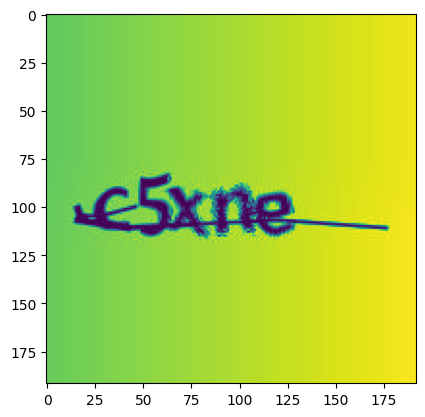

In [16]:
model.eval()
inputs, classes = next(iter(test_loader))
#print(inputs.shape)
#print(classes.shape)

plt.imshow(inputs[0].numpy()[0])
print("Real:", "".join(all_int_to_character(classes[0].numpy().tolist())))
inputs = inputs[0:1].to(device)
#print(inputs.shape)
out = model(inputs)
out = torch.reshape(out, (1, 36, 5))
_, predicted = torch.max(out.data, 1)
predicted = predicted[0]
#print(predicted)
print("Predicted:", "".join(all_int_to_character(predicted.cpu().detach().numpy().tolist())))

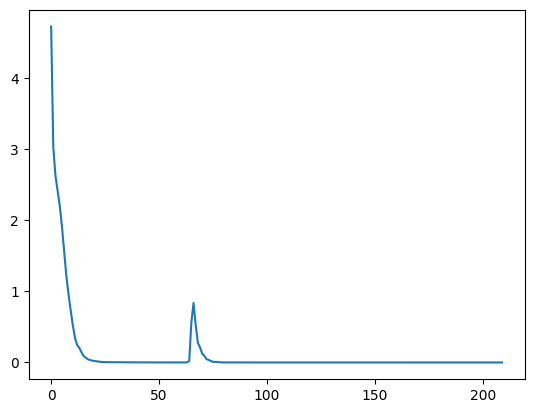

In [17]:
plt.plot(losses_list)
plt.show()

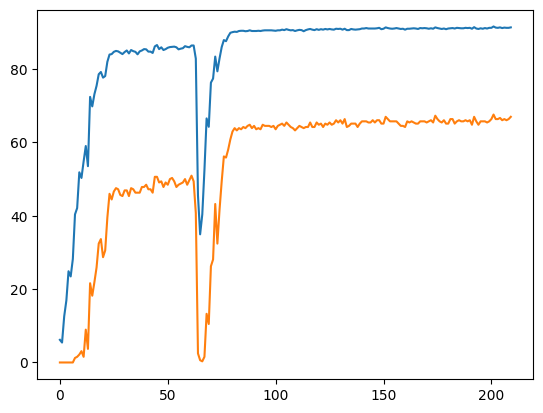

In [18]:
plt.plot(accuracies)
plt.plot(full_accuracies)
plt.show()

[]

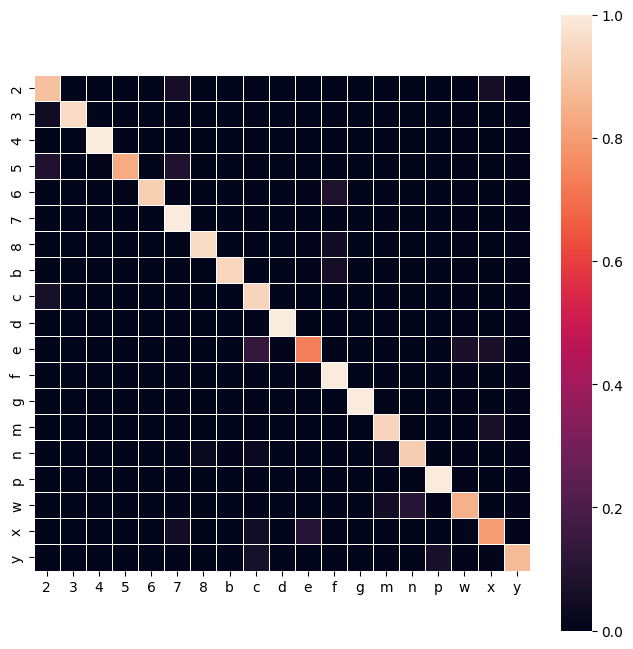

In [19]:
fig, ax = plt.subplots(figsize=(8,8))
df_cm = compute_confusion_matrix(model, test_loader)
sn.heatmap(df_cm, square=True, annot=False, linewidths=.5)
plt.plot()

In [ ]:
import pickle as pkl

In [ ]:
file = open(results_path+"Losses/cnn1_loss_curve.pkl", "wb")
#pkl.dump(losses_list,file )
file.close()
file = open(results_path+"Losses/cnn1_char_accuracy_curve.pkl", "wb")
#pkl.dump(accuracies,file )
file.close()
file = open(results_path+"Losses/cnn1_captcha_accuracy_curve.pkl", "wb")
#pkl.dump(full_accuracies,file )
file.close()
file = open(results_path+"Losses/cnn1_loss_curve.pkl", "rb")
losses_list_p = pkl.load(file)
file.close()
#file.close()

In [ ]:
plt.plot([0, 5, 10])
plt.plot([0, 0, 2])
plt.legend(["Char accuracy", "Full Captcha accuracy"])
plt.show()